## Task 2.2
### Алгоритм рекомендацій, створення підбірки рекомендованих фільмів для користувачів

#### 1. Виконуємо пункти 1-6 з попередньої частини. 

In [22]:
from scipy.sparse.linalg import svds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = 'ratings.csv'

df = pd.read_csv(file_path)

ratings_matrix = df.pivot(index='userId', columns='movieId', values='rating')

ratings_matrix = ratings_matrix.dropna(thresh=50, axis=0)
ratings_matrix = ratings_matrix.dropna(thresh=50, axis=1)

# amend NaN value by avg value for each film
ratings_matrix_filled = ratings_matrix.apply(lambda col: round(col.fillna(col.mean()), 2), axis=0)

# Обчислення середнього рейтингу кожного користувача
R = ratings_matrix_filled.values
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

#### 2. Виконуємо SVD

In [23]:
U, sigma, Vt = svds(R_demeaned, k=2)

### Tests

#### Проексперементуйте, як впливає розмірність даних, що залишаємо (параметр k), на фінальний результат роботи алгоритму. Наскільки точно алгоритм відновлює оцінки, що вже стояли? Як це впливає на прогнозовані оцінки?

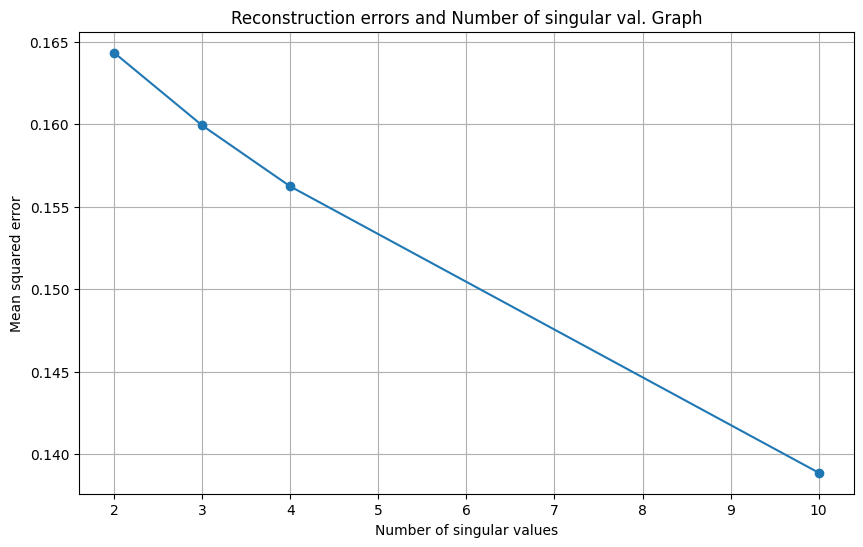

In [24]:
# k відповідає за розмірність даних, яку зберігаємо
def svd_reconstruction(R_demeaned, key, user_ratings_mean):
    U, S, Vt = svds(R_demeaned, k=key)
    S = np.diag(S)
    reconstructed_R = np.dot(U, np.dot(S, Vt)) + user_ratings_mean.reshape(-1, 1)
    return reconstructed_R


keys = [2, 3, 4, 10]
reconstructions = []

for k in keys:
    reconstructed_R = svd_reconstruction(R_demeaned, k, user_ratings_mean)
    # Для кожного значення
    # k відновлюємо матрицю та обчислюємо середньоквадратичну помилкy
    error = np.mean((R - reconstructed_R) ** 2)
    reconstructions.append(error)

plt.figure(figsize=(10, 6))
plt.plot(keys, reconstructions, marker='o')
plt.title('Reconstruction errors and Number of singular val. Graph')
plt.xlabel('Number of singular values')
plt.ylabel('Mean squared error')
plt.grid(True)
plt.show()

### Conclusions: 
#### Чим меньша k, тим менш точно відбувається відновлення, але швидкість обчислення виростає
#### Отже, оскліьки зростає кількість помилок, значить зростає похибка самого підбору схожих данних для юзерів
#### Це можна використовувати аби юзеру рукомендувало не однотипні серіали на базі того зо він подивився, а разброс був більший


#### 3. За допомогою множення відповідних матриць, отримуємо матрицю, вже з прогнозованими оцінками. Також, не забуваємо додати відповідні середні значення кожного рядка, що ми віднімали при підготовці даних.

In [25]:
sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=ratings_matrix.columns, index=ratings_matrix.index)

#### 5. Наскільки оцінки, що вже були виставлені в початковій матриці відрізняються від тих, що ми отримали в матриці з прогнозами? Як впливає на це параметр k з пункту 2?

In [26]:
print(R_demeaned)
print(all_user_predicted_ratings)
# all_user_predicted_ratings будуть близькими до початкових, але можуть мати деякі відхилення залежно від значення. Менше значення k може призвести до більш значних відхилень.

[[ 0.15315403 -0.41684597  0.15315403 ...  0.12315403  0.04315403
   0.19315403]
 [ 0.30105134 -0.15894866  0.35105134 ...  0.38105134  0.30105134
   0.45105134]
 [ 0.16555012  0.27555012  0.27555012 ...  0.24555012  0.16555012
   0.31555012]
 ...
 [ 0.29616137 -0.27383863  0.23616137 ...  0.26616137  0.18616137
   0.33616137]
 [-1.00625917 -1.50625917  0.43374083 ...  0.46374083  0.38374083
   0.53374083]
 [ 1.07801956 -0.49198044  1.07801956 ...  0.57801956 -0.42198044
   0.57801956]]
[[4.11251477 3.59869126 4.14697238 ... 4.14001485 4.0654694  4.2420463 ]
 [3.81961575 3.36670937 3.85211988 ... 3.85197321 3.78436676 3.9374806 ]
 [4.03865135 3.59934658 4.01516076 ... 3.86052128 3.84395402 4.05773499]
 ...
 [3.95214382 3.532372   3.96127884 ... 3.90219792 3.85823579 4.02504841]
 [3.65825363 3.1711904  3.75163792 ... 3.91555365 3.79080197 3.88615241]
 [4.24839177 3.63903896 4.28235279 ... 4.25471774 4.17246181 4.39005614]]


#### 6. Створити нову таблицю, де будуть видалені оцінки фільмів, що вже існували до прогнозування (клітинки клітинки в яких вже стояли значення до прогнозування можна заповнити NaN), і залишити лише спрогнозовані оцінки.

In [27]:
predicted = ratings_matrix.copy()

# Заміна початкових оцінок на NaN
predicted[~ratings_matrix.isna()] = np.nan

# Вставка спрогнозованих оцінок на місце NaN
predicted.fillna(round(preds_df, 2), inplace=True)

print(predicted)

movieId  1       2       6       10      11      16      17      19      \
userId                                                                    
1          4.11    3.60    4.15    3.65    3.80    4.09    3.96    2.78   
4          3.82    3.37    3.85    3.41    3.54    3.81    3.69    2.65   
6          4.04    3.60    4.02    3.69    3.70    3.78    3.72    2.80   
7          3.90    3.40    3.93    3.45    3.60    3.90    3.76    2.63   
10         3.81    3.42    3.84    3.45    3.57    3.80    3.70    2.79   
...         ...     ...     ...     ...     ...     ...     ...     ...   
605        3.90    3.43    3.93    3.48    3.61    3.88    3.76    2.70   
606        3.82    3.33    3.92    3.32    3.59    4.07    3.87    2.64   
607        3.95    3.53    3.96    3.59    3.67    3.85    3.76    2.83   
608        3.66    3.17    3.75    3.16    3.43    3.92    3.72    2.51   
610        4.25    3.64    4.28    3.70    3.87    4.19    4.04    2.66   

movieId  21      25     

#### 8. Створити фукнцію, що буде для певного користувача, вибирати 10 фільмів, з найбільшим прогнозованим рейтингом.

In [28]:
df_movies = pd.read_csv('movies.csv')

def recommend_movies(user_id, preds_df, movies_df, ratings_matrix, num_recommendations=10):
    user_pred_ratings = preds_df.loc[user_id]

    # Викидуємо оцінені юзером фільми
    user_rated_movies = ratings_matrix.loc[user_id].dropna().index
    user_pred_ratings = user_pred_ratings.drop(user_rated_movies, errors='ignore').sort_values(ascending=False)

    # Схрещуємо інфу про фільми та предіктабл рейтинг
    recommendations = (movies_df.set_index('movieId')
                       .loc[user_pred_ratings.index]
                       .assign(predicted_rating=user_pred_ratings.values))

    # Берем топ 10 рекомендацій для юзера
    top_recommendations = recommendations.head(num_recommendations)

    return top_recommendations[['title', 'genres', 'predicted_rating']]

user_id = 200
top10 = recommend_movies(user_id, preds_df, df_movies, ratings_matrix)
print(top10)

                                                     title  \
movieId                                                      
858                                  Godfather, The (1972)   
750      Dr. Strangelove or: How I Learned to Stop Worr...   
527                                Schindler's List (1993)   
1276                                 Cool Hand Luke (1967)   
912                                      Casablanca (1942)   
1208                                 Apocalypse Now (1979)   
1252                                      Chinatown (1974)   
1221                        Godfather: Part II, The (1974)   
2329                             American History X (1998)   
904                                     Rear Window (1954)   

                                   genres  predicted_rating  
movieId                                                      
858                           Crime|Drama          4.317121  
750                            Comedy|War          4.281316  
527    